# Importamos y Cogemos Material Necesario

Librerías

In [1]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

2023-05-16 12:44:04.721889: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-16 12:44:04.723379: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-16 12:44:04.756317: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-16 12:44:04.756899: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 12:44:05.409766: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Cogemos Imágenes de Perros y Gatos

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2023-05-16 12:44:06--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolviendo storage.googleapis.com (storage.googleapis.com)... 172.217.17.16, 216.58.209.80, 142.250.184.176, ...
Conectando con storage.googleapis.com (storage.googleapis.com)[172.217.17.16]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 68606236 (65M) [application/zip]
Guardando como: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65,43M  10,3MB/s    en 6,4s    

2023-05-16 12:44:12 (10,2 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ guardado [68606236/68606236]



Creamos los directorios de perros y gatos

In [3]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Importamos el modelo InceptionV3

In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3


Hacemos uso de todas las capas del modelo excepto la última capa densa (totalmente conectada)

In [5]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

87910968/87910968 [==============================] - 8s 0us/step


Hacemos que las capas no sean entrenables (podemos dejar alguna más para entrenar nosotros, pero tenemos que tener cuidado con el overfitting)



In [6]:
for layer in pre_trained_model.layers:
  layer.trainable = False

Vemos la red que tenemos

In [7]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

# Entrenamos el modelo

Definimos un callback si el accuracy supera el 95%

In [8]:

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

# Entrenamos la red

In [9]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(pre_trained_model.output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(learning_rate=0.0001),  #Usamos RMSprop para el learningrate: tambien podemos usar Adam o Adagrad
              loss = 'binary_crossentropy',  #Usamnos binary_crossentropy porque tenemos 2 clases a predecir (perros y gatos)
              metrics = ['acc'])

Hacemos data augmentation

In [10]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Entrenamos la red

In [11]:

callbacks = myCallback()
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2,
            callbacks=[callbacks])

Epoch 1/20


2023-05-16 12:44:24.657774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-16 12:44:57.278000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 - 42s - loss: 1.0568 - acc: 0.8510 - val_loss: 1.2414 - val_acc: 0.6880 - 42s/epoch - 421ms/step
Epoch 2/20
100/100 - 39s - loss: 0.3714 - acc: 0.8925 - val_loss: 0.1671 - val_acc: 0.9520 - 39s/epoch - 394ms/step
Epoch 3/20
100/100 - 41s - loss: 0.3236 - acc: 0.9050 - val_loss: 0.1603 - val_acc: 0.9360 - 41s/epoch - 414ms/step
Epoch 4/20
100/100 - 38s - loss: 0.2278 - acc: 0.9205 - val_loss: 0.1209 - val_acc: 0.9610 - 38s/epoch - 382ms/step
Epoch 5/20
100/100 - 37s - loss: 0.2249 - acc: 0.9230 - val_loss: 0.2159 - val_acc: 0.9300 - 37s/epoch - 372ms/step
Epoch 6/20
100/100 - 36s - loss: 0.2257 - acc: 0.9220 - val_loss: 0.1195 - val_acc: 0.9590 - 36s/epoch - 362ms/step
Epoch 7/20
100/100 - 37s - loss: 0.2205 - acc: 0.9185 - val_loss: 0.0912 - val_acc: 0.9620 - 37s/epoch - 370ms/step
Epoch 8/20
100/100 - 37s - loss: 0.1874 - acc: 0.9245 - val_loss: 0.1679 - val_acc: 0.9470 - 37s/epoch - 366ms/step
Epoch 9/20
100/100 - 41s - loss: 0.1847 - acc: 0.9345 - val_loss: 0.1377 - val_acc:

Dibujamos las métricas relevantes

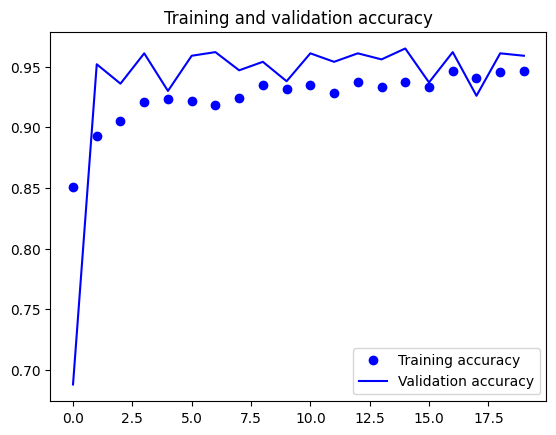

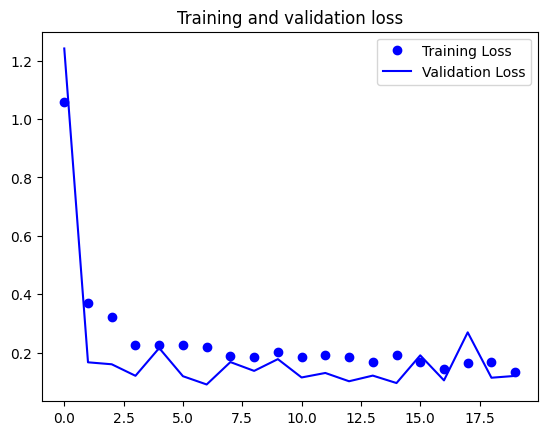

In [12]:

import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Uso del modelo para predecir imágenes

In [15]:
# import numpy as np
# from google.colab import files
# from keras.preprocessing import image

# uploaded = files.upload()

# for fn in uploaded.keys():

#   # predicting images
#   path = fn
#   img = image.load_img(path, target_size=(150, 150))
#   x = image.img_to_array(img)
#   x = np.expand_dims(x, axis=0)

#   images = np.vstack([x])
#   classes = model.predict(images, batch_size=10)
#   print(fn)
#   print(classes)